TODO

1. Get data on all-stars
2. Get data on groupings of teams...(contender, mid-tier, rebuilding) (>50 wins, >40 wins, rest)??
3. Get team salary data



In [58]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math

In [3]:
##LOADING 2018 DATA (2017-2018 NBA Season)

team_per100 = pd.read_csv('../Data/Team/2018/team_per100.csv')
opp_per100 = pd.read_csv('../Data/Team/2018/opp_per100.csv')
misc = pd.read_csv('../Data/Team/2018/misc.csv', skiprows = 1)

shooting_col_names = ['Rk', 'Team', 'G', 'MP', 'FG%', 'Dist.',
                      'Pct_FGA_by_dist_2P' , 'Pct_FGA_by_dist_0-3', 'Pct_FGA_by_dist_3-10', 'Pct_FGA_by_dist_10-16', 'Pct_FGA_by_dist_16-3pt', 'Pct_FGA_by_dist_3P',
                     'FGP_by_dist_2P' , 'FGP_by_dist_0-3', 'FGP_by_dist_3-10', 'FGP_by_dist_10-16', 'FGP_by_dist_16-3pt', 'FGP_by_dist_3P',
                     '2FG_%assisted','2FG_dunks_%FGA','2FG_dunks_made','2FG_layups_%FGA','2FG_layups_made',
                     '3FG_%assisted','3FG_corner_%3PA','3FG_corner_3P%','3FG_heaves_att','3FG_heaves_made']

team_shooting = pd.read_csv('../Data/Team/2018/team_shooting.csv', names = shooting_col_names, skiprows = 3)
opp_shooting = pd.read_csv('../Data/Team/2018/opp_shooting.csv', names = shooting_col_names, skiprows = 2)

In [42]:
## Selecting Specific Columns
team_per100_select = team_per100[['Team' ,'MP', '3PA', '3P%', '2PA', '2P%', 'FTA', 'FT%', 'ORB', 'DRB','AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']]
opp_per100_select = opp_per100[['Team' ,'MP', '3PA', '3P%', '2PA', '2P%', 'FTA', 'FT%', 'ORB', 'DRB','AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']]

team_shooting_select = team_shooting[['Team', 'Dist.', 'Pct_FGA_by_dist_2P','Pct_FGA_by_dist_0-3','Pct_FGA_by_dist_3-10','Pct_FGA_by_dist_10-16','Pct_FGA_by_dist_16-3pt','Pct_FGA_by_dist_3P',
                                     'FGP_by_dist_2P','FGP_by_dist_0-3','FGP_by_dist_3-10','FGP_by_dist_10-16','FGP_by_dist_16-3pt','FGP_by_dist_3P','3FG_%assisted','3FG_corner_%3PA','3FG_corner_3P%']]
opp_shooting_select = opp_shooting[['Team', 'Dist.', 'Pct_FGA_by_dist_2P','Pct_FGA_by_dist_0-3','Pct_FGA_by_dist_3-10','Pct_FGA_by_dist_10-16','Pct_FGA_by_dist_16-3pt','Pct_FGA_by_dist_3P',
                                     'FGP_by_dist_2P','FGP_by_dist_0-3','FGP_by_dist_3-10','FGP_by_dist_10-16','FGP_by_dist_16-3pt','FGP_by_dist_3P','3FG_%assisted','3FG_corner_%3PA','3FG_corner_3P%']]

#duplicate TOV rates, must remove
misc_select = misc.drop(['Rk','SOS', 'SRS','Arena', 'TOV%', 'TOV%.1'], axis=1)

In [43]:
## Renaming OPP columns to ahve prefix 'opp_'
opp_per100_select = opp_per100_select.add_prefix('opp_')
opp_shooting_select = opp_shooting_select.add_prefix('opp_')

#Rename Misc columns eFG%.1 and FT/FGA.1 to have prefix opp
misc_select.rename(columns={'eFG%.1':'opp_eFG%'}, inplace=True)
misc_select.rename(columns={'FT/FGA.1':'opp_FT/FGA'}, inplace=True)

In [44]:
## Creating Joined Table

j1 = team_per100_select.merge(opp_per100_select, left_on = 'Team', right_on = 'opp_Team', how = 'left')
j2 = j1.merge(team_shooting_select, on='Team', how = 'left')
j3 = j2.merge(opp_shooting_select, left_on = 'Team', right_on = 'opp_Team', how = 'left')
j4 = j3.merge(misc_select, on='Team', how = 'left')

In [45]:
## Creating flag for Playoff team
j4['Playoff'] = j4.apply(lambda row: 1 if '*' in row.Team else 0, axis=1)


#Creating categorical for Contender, Mid-Tier, Rebuilding
def tier (row):
    if row['W'] >= 50 :
        return 'Contender'
    elif row['W'] >= 40:
        return 'Mid-Tier'
    else:
        return 'Rebuilding'
    
j4['Tier'] = j4.apply(lambda row: tier(row), axis = 1)
    
#j4['Tier'] = j4.apply(lambda row: 'Contender' if row.W>=50  else if row.W>=40 'Mid-Tier' else 'Rebuilding', axis=1)

In [46]:
#Calculate a normalized standard dev = std/mean of column

team_summary = team_per100_select.describe().T
sigma = np.array(team_summary[['std']])
mu = np.array(team_summary[['mean']])
team_summary['norm_std'] = sigma/mu
team_summary.sort_values(by='norm_std', axis = 0, ascending = False)

,count,mean,std,min,25%,50%,75%,max,norm_std
BLK,30.0,4.926667,0.791303,3.600,4.40000,4.8500,5.3000,7.500,0.160616
3PA,30.0,29.606667,3.997407,23.300,27.27500,29.4000,31.4750,43.200,0.135017
FTA,30.0,22.130000,2.237324,17.500,20.42500,22.2000,23.5250,27.300,0.101099
ORB,30.0,9.920000,0.961464,8.400,9.25000,9.9500,10.5000,12.800,0.096922
STL,30.0,7.883333,0.715871,6.300,7.60000,7.8500,8.1750,9.300,0.090808
2PA,30.0,58.310000,4.629467,42.800,56.37500,58.7000,60.1000,66.000,0.079394
AST,30.0,23.716667,1.785977,20.100,22.77500,23.5000,23.9750,29.300,0.075305
PF,30.0,20.276667,1.425551,17.400,19.35000,20.1500,20.9750,24.400,0.070305
TOV,30.0,14.573333,0.917242,12.800,14.00000,14.5500,15.2750,16.400,0.062940
2P%,30.0,0.510767,0.022092,0.478,0.49350,0.5065,0.5250,0.560,0.043252


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115a41f28>,
      dtype=object)

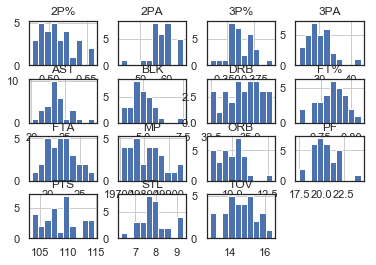

In [47]:
team_per100_select.hist()

In [48]:
#Send correlation to .xlsx to manually select variables that make sense and are not too multicollinear
j4.corr().to_csv('correlation_table.csv')

In [49]:
#Sorting table by different values
#j4.sort_values(by='Tier', axis = 0, ascending = False)

In [50]:
#Plot Wins by Playoff and Non Playoff
# playoff = j4.loc[j4['Playoff'] == 1]
# non_playoff = j4.loc[j4['Playoff'] == 0]

# sns.distplot(j4[['W']], color="y")
# sns.distplot(playoff[['W']], hist=False, color="g")
# sns.distplot(non_playoff[['W']], hist=False, color="r")


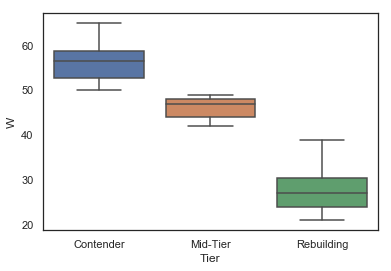

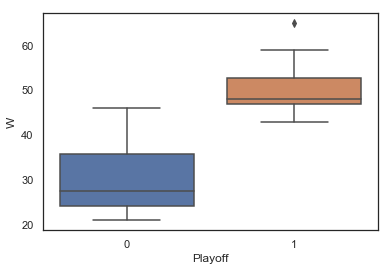

In [51]:
#Wins by Tier and Playoff
plt.figure()
sns.boxplot(x="Tier", y="W", data=j4)
plt.figure()
sns.boxplot(x="Playoff", y="W", data=j4)

In [52]:
#j4.select_dtypes(exclude='object')

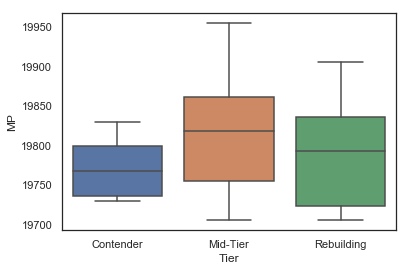

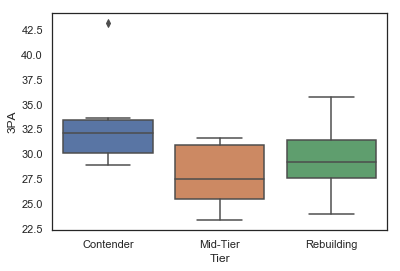

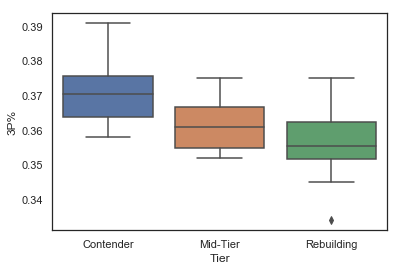

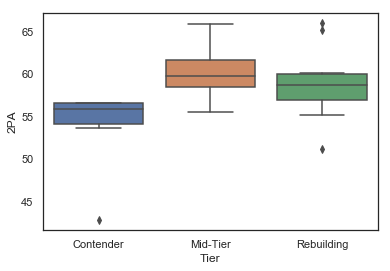

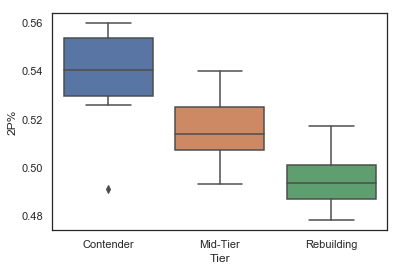

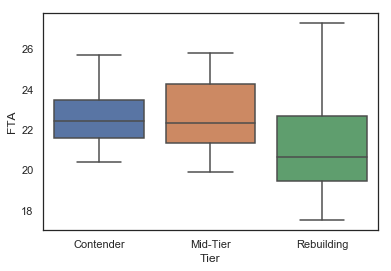

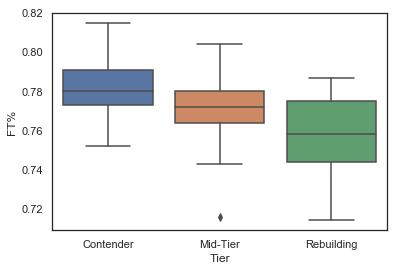

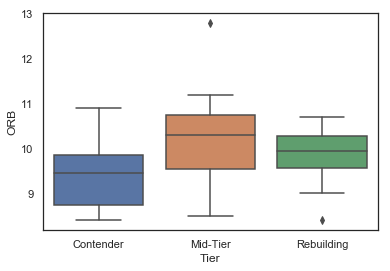

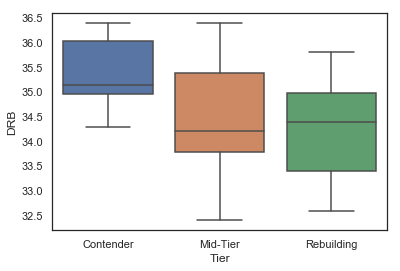

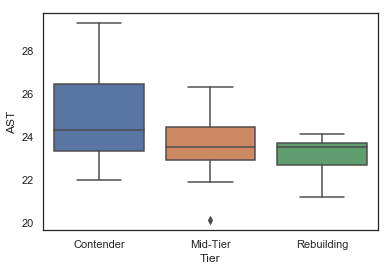

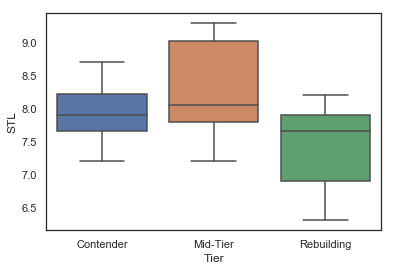

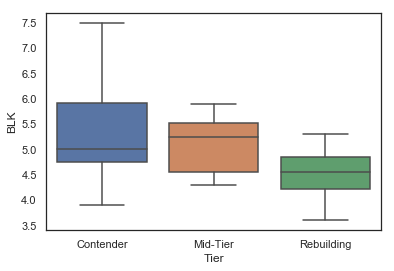

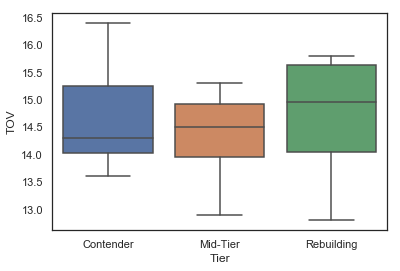

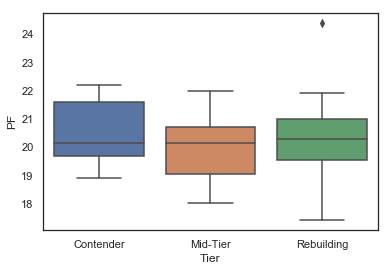

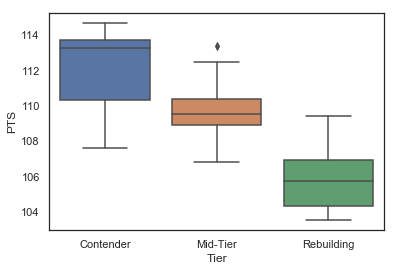

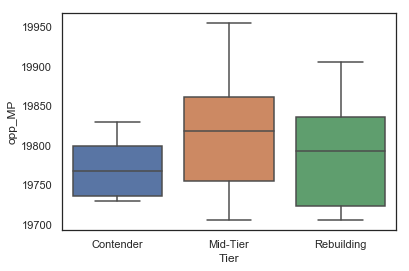

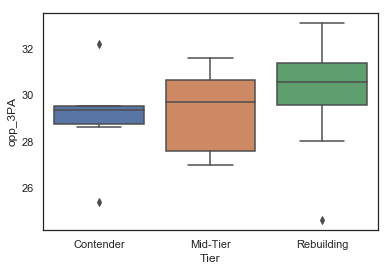

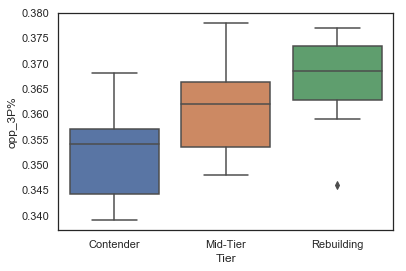

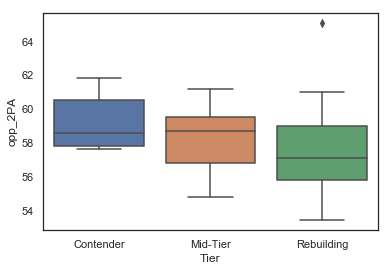

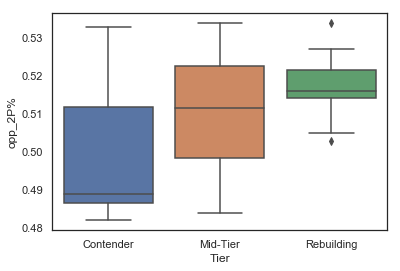

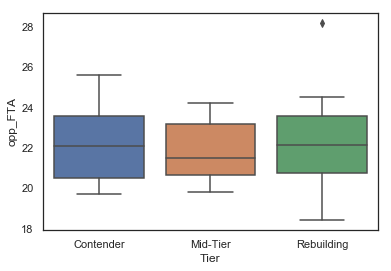

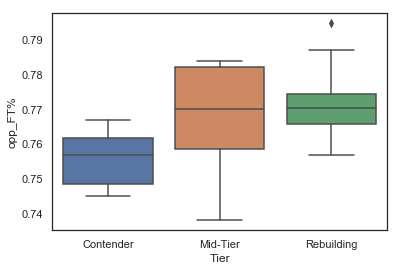

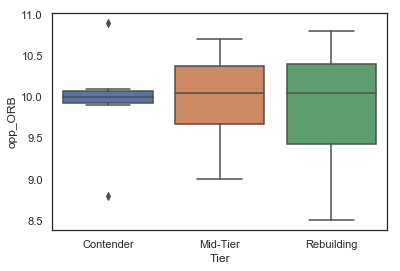

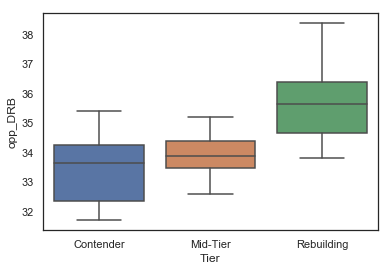

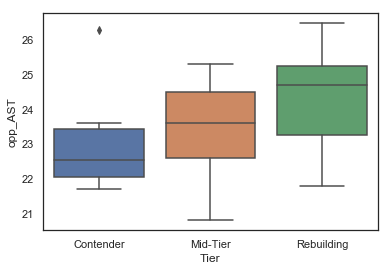

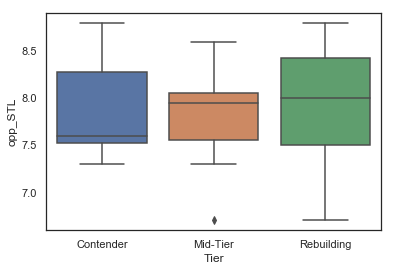

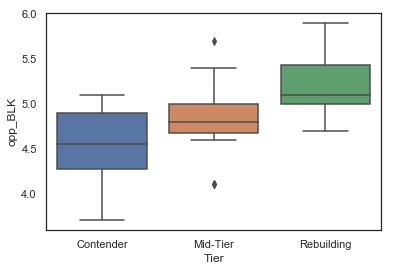

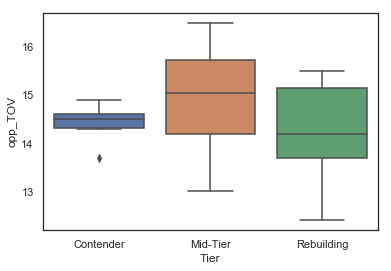

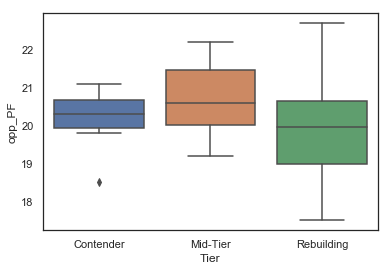

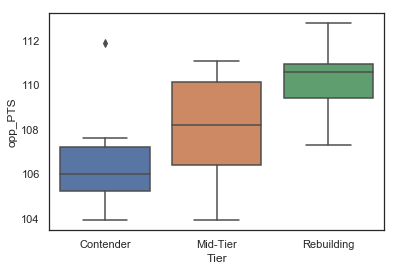

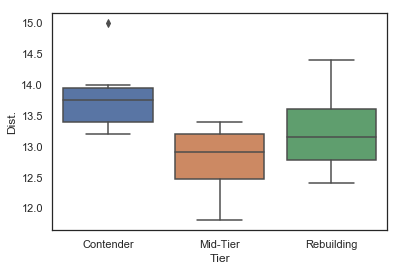

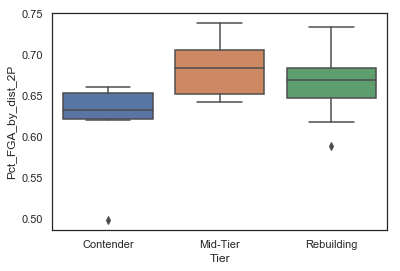

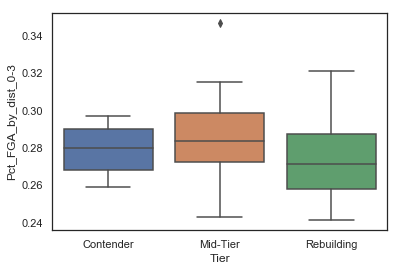

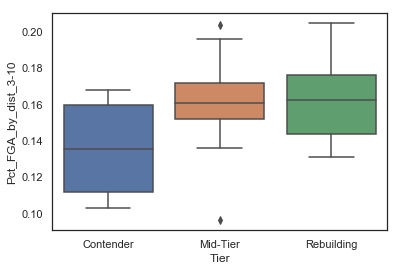

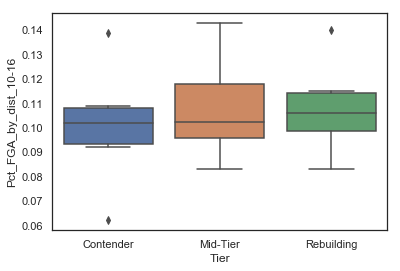

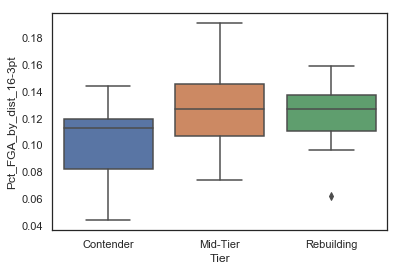

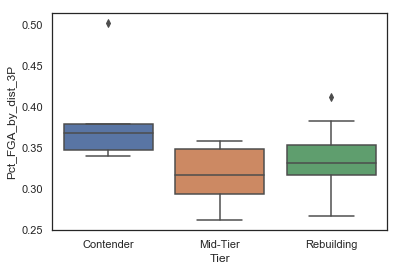

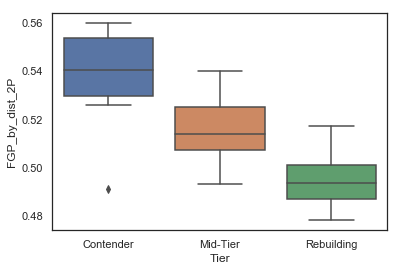

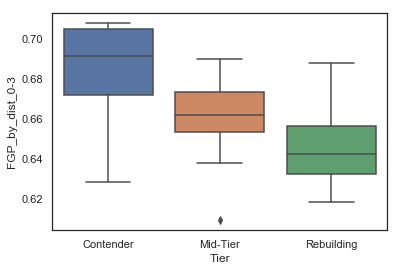

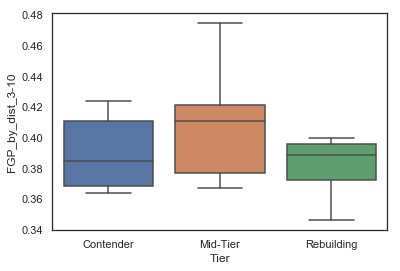

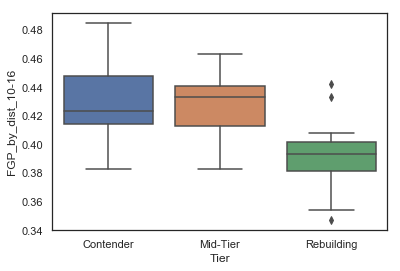

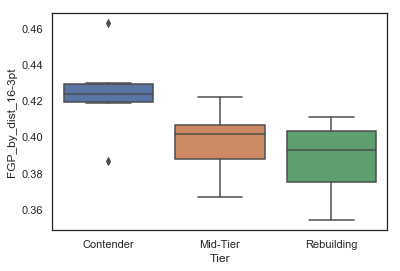

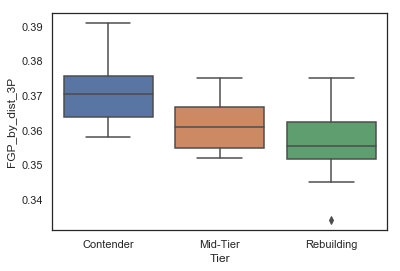

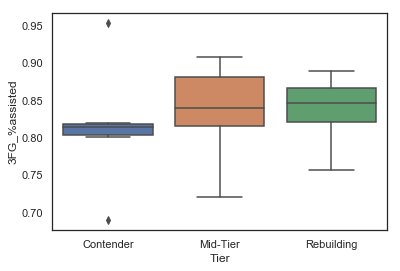

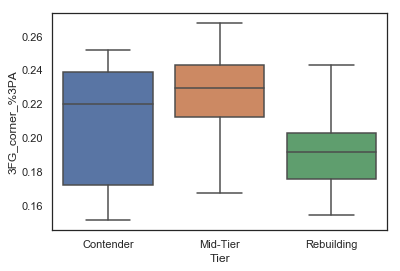

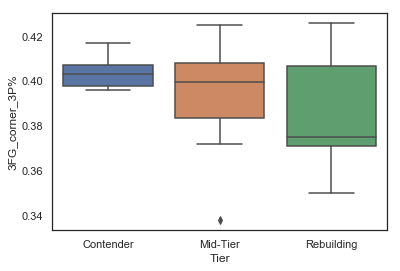

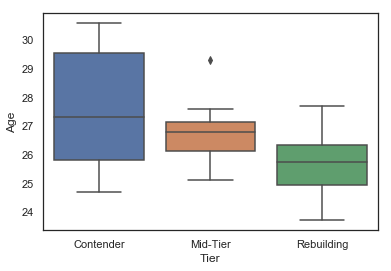

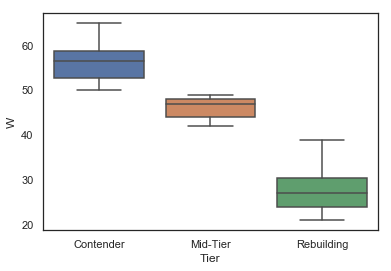

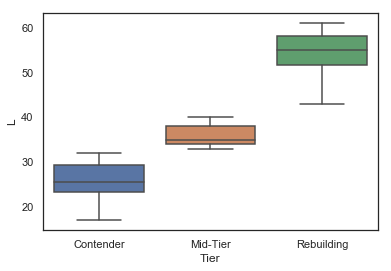

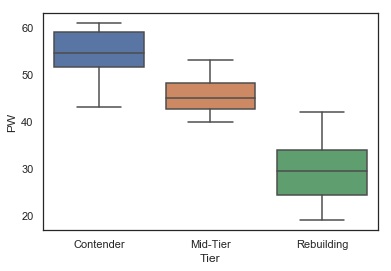

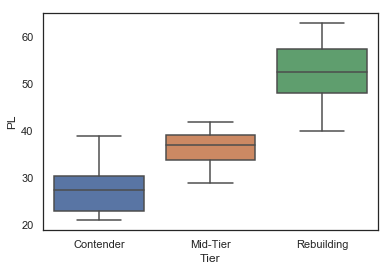

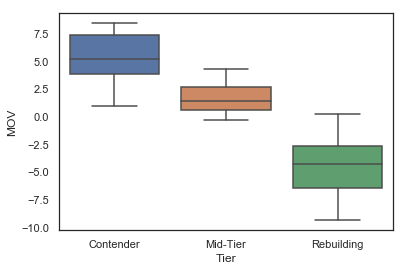

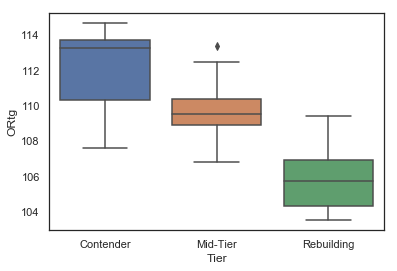

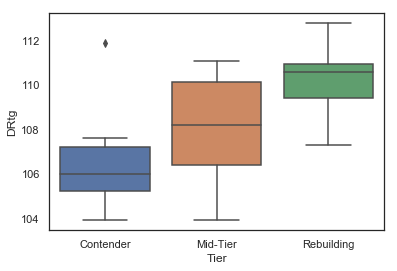

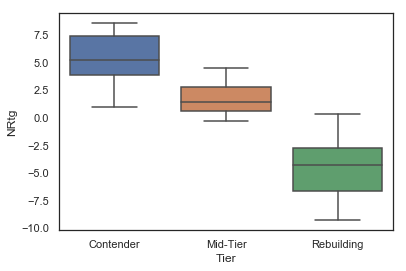

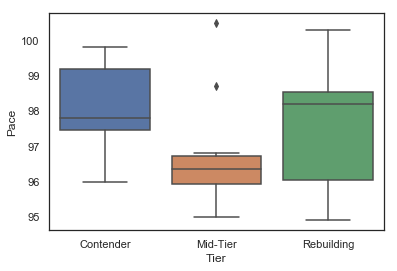

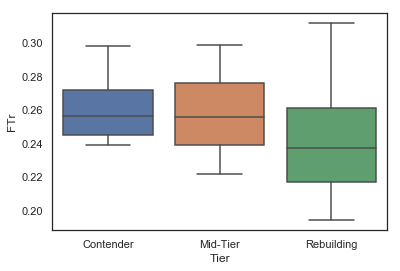

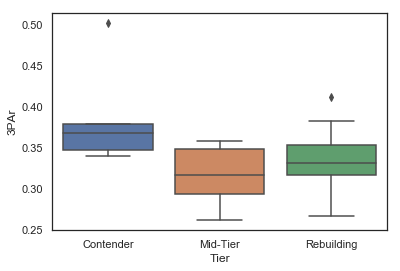

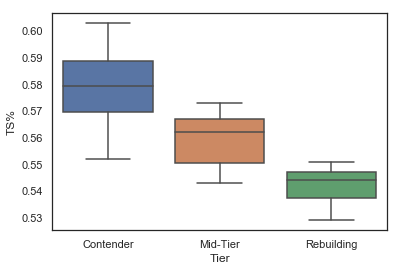

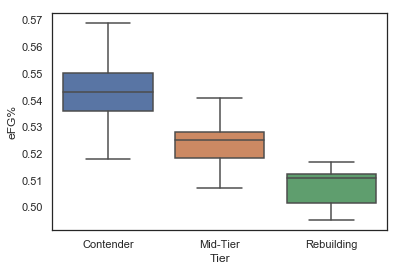

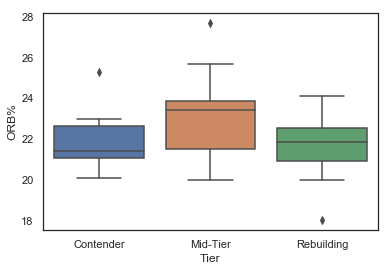

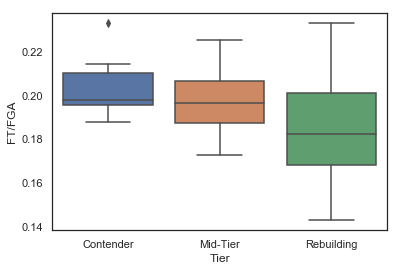

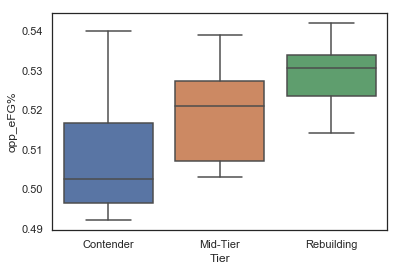

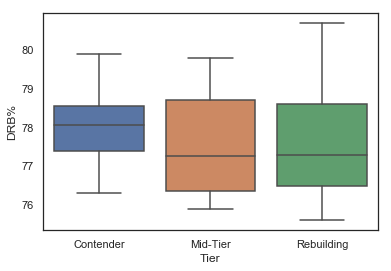

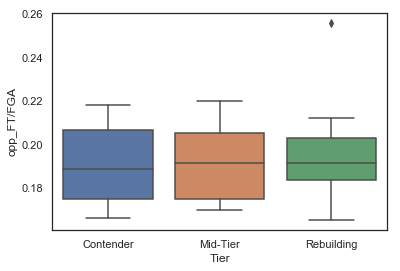

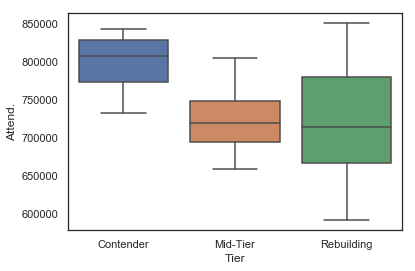

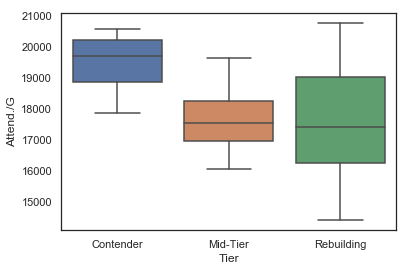

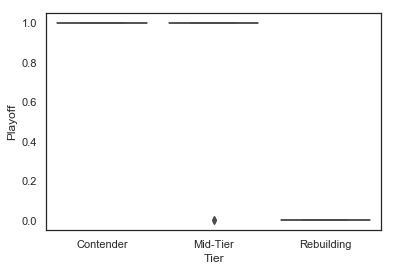

In [53]:
for i in j4.select_dtypes(exclude='object'):
    plt.figure()
    sns.boxplot(x="Tier", y=i, data=j4)


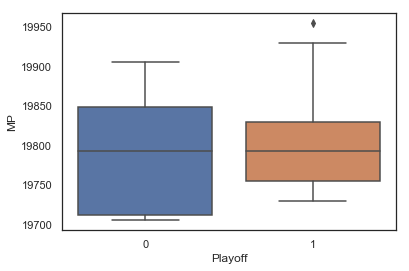

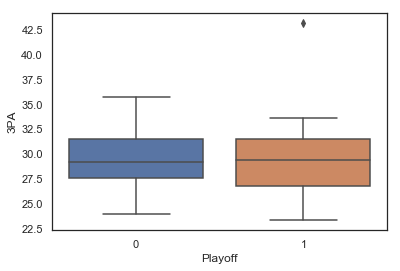

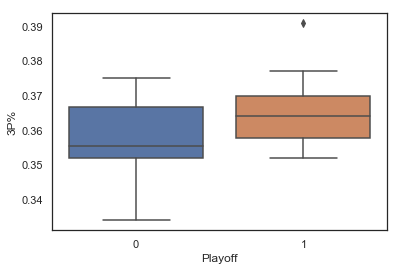

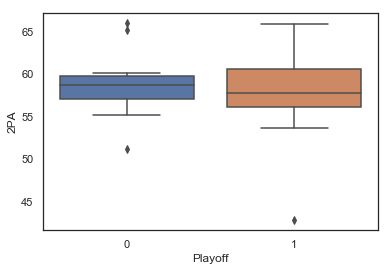

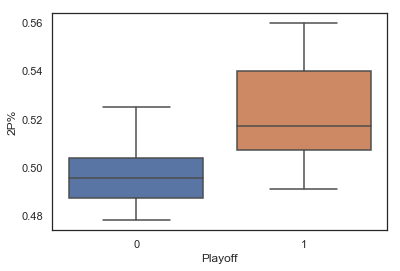

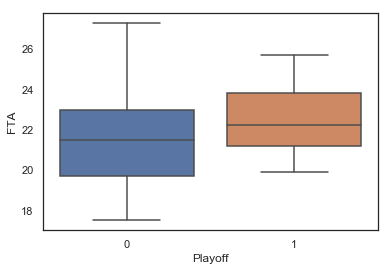

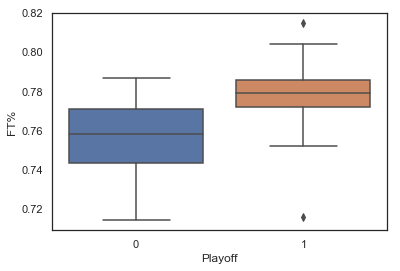

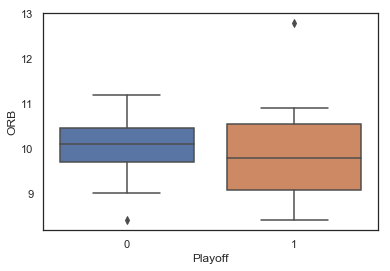

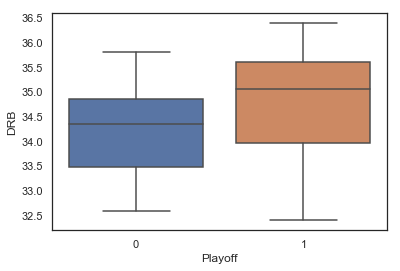

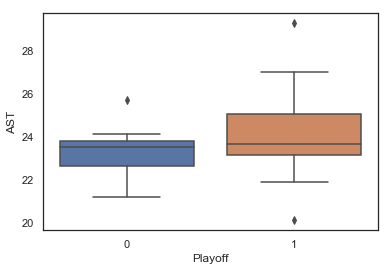

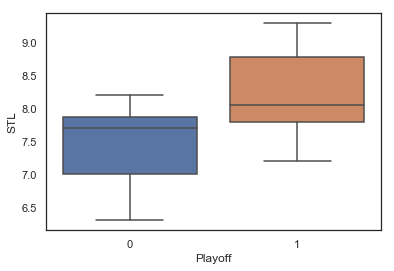

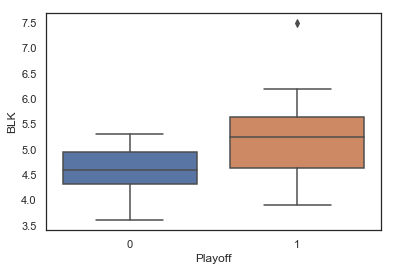

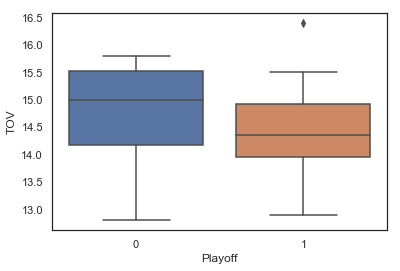

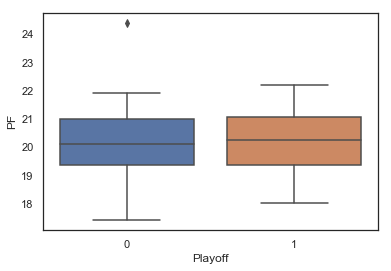

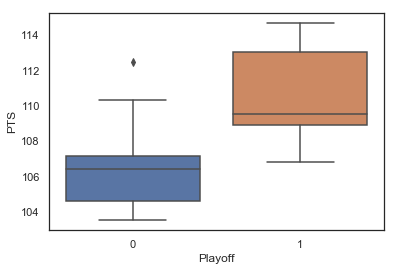

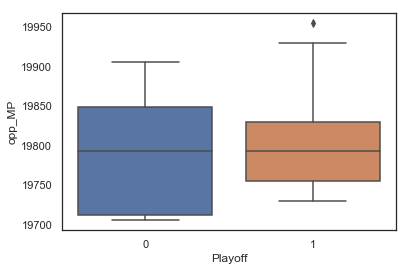

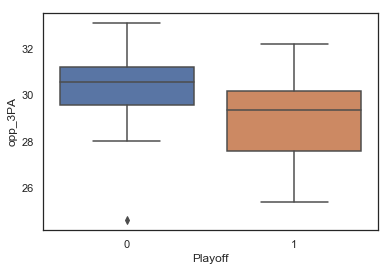

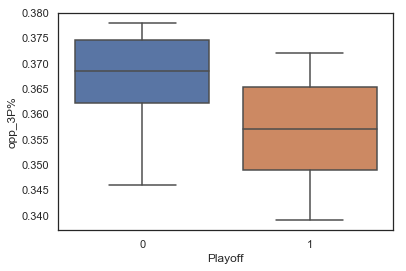

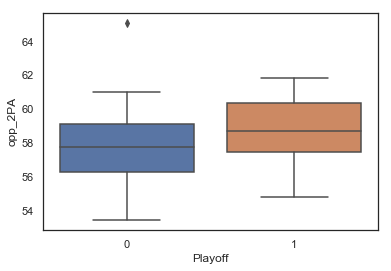

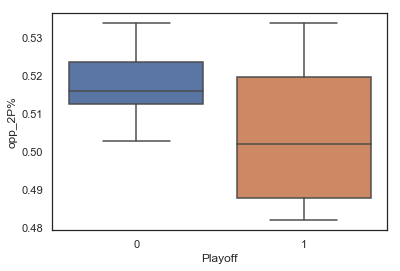

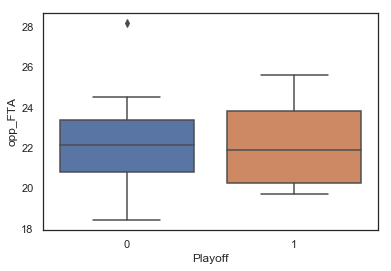

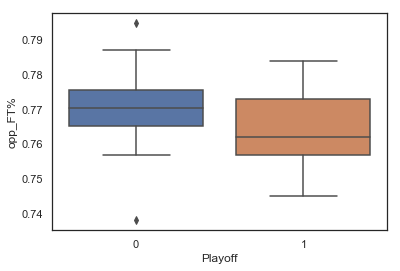

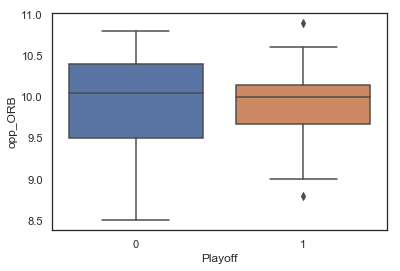

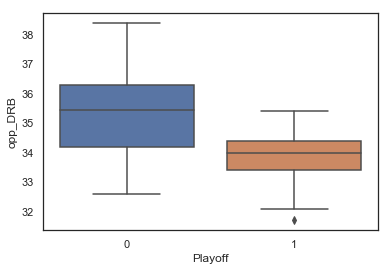

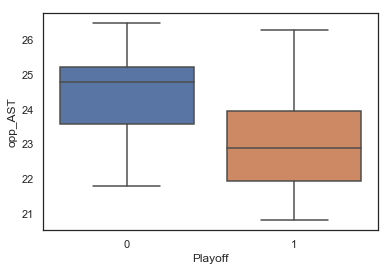

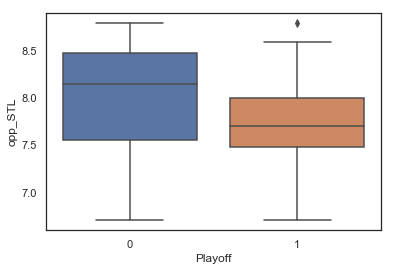

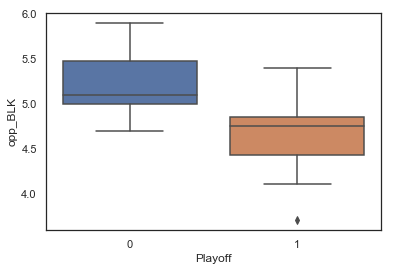

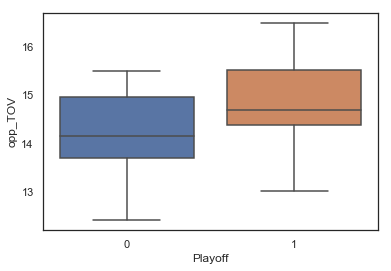

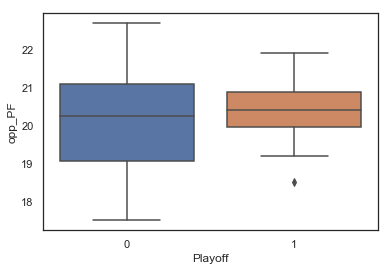

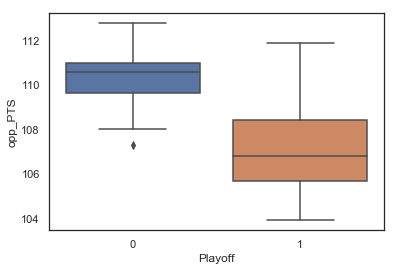

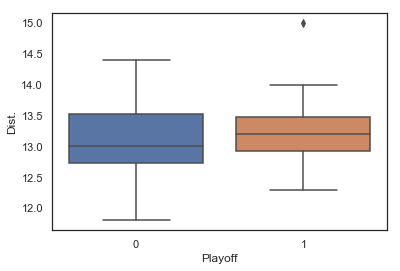

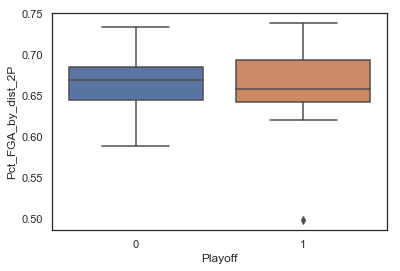

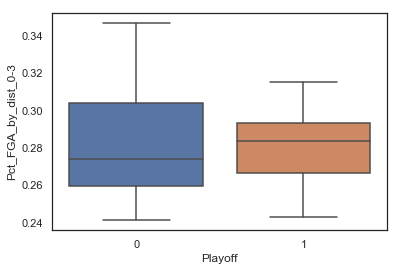

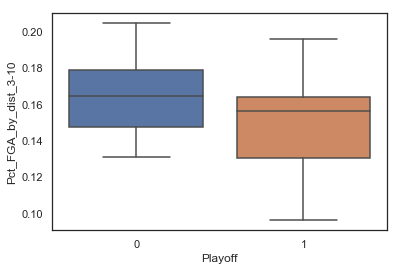

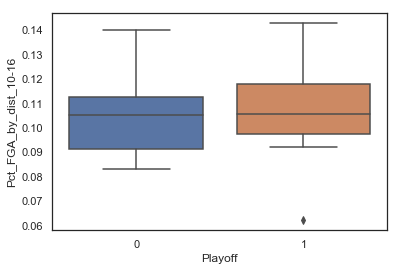

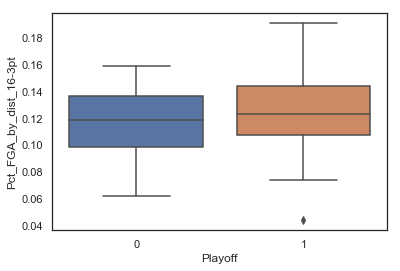

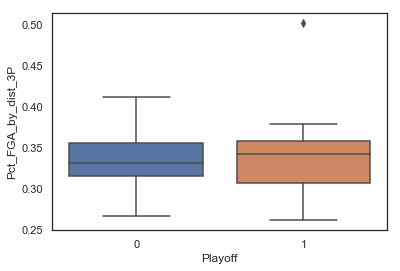

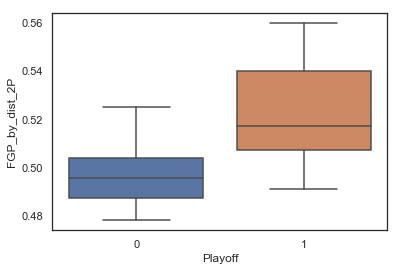

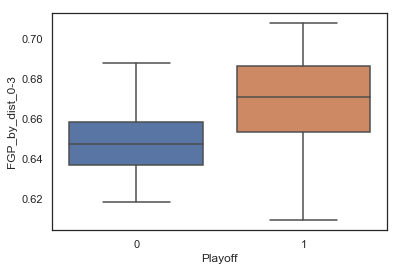

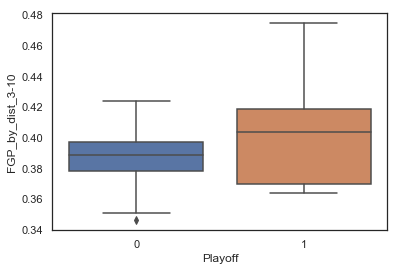

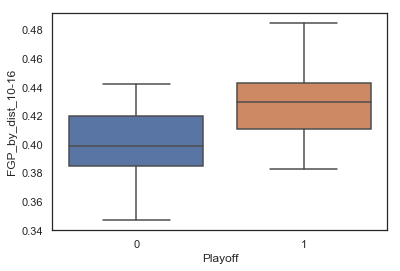

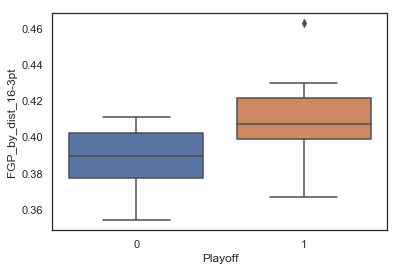

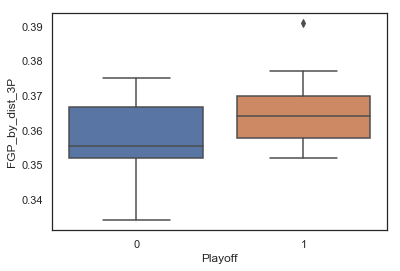

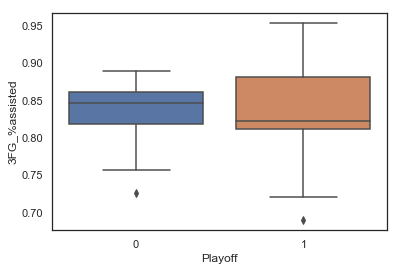

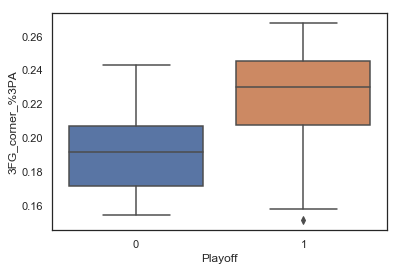

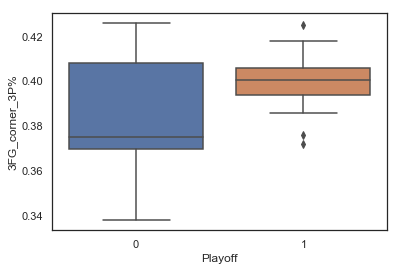

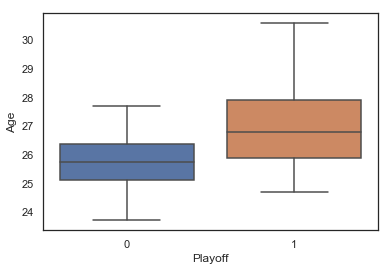

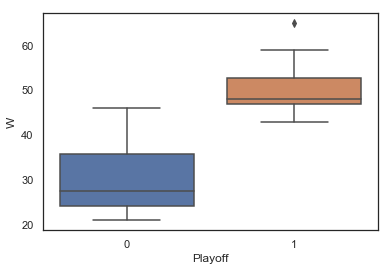

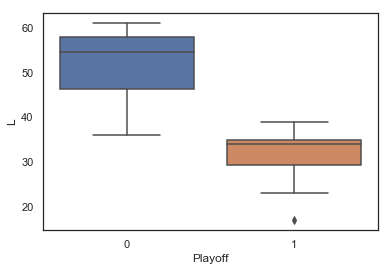

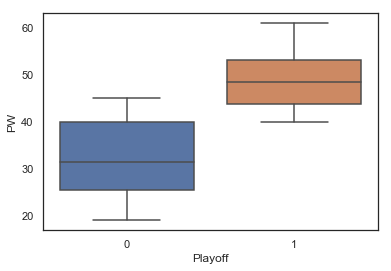

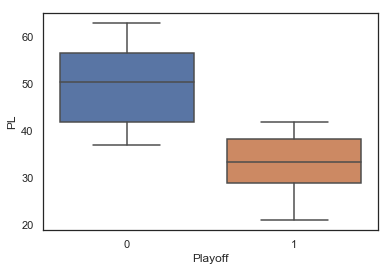

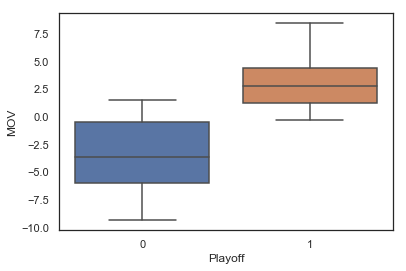

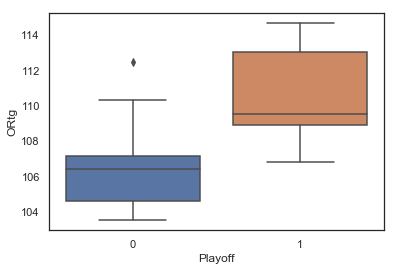

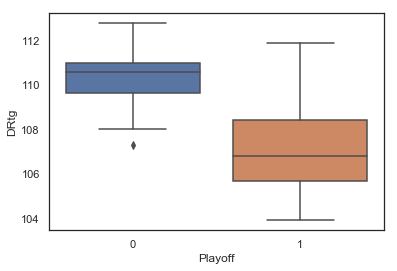

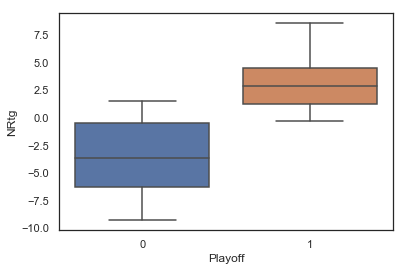

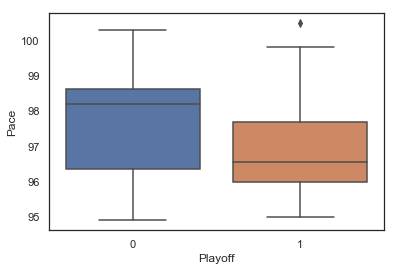

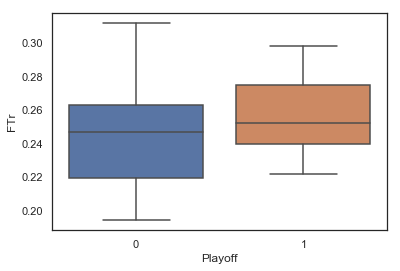

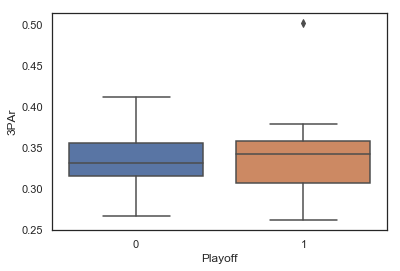

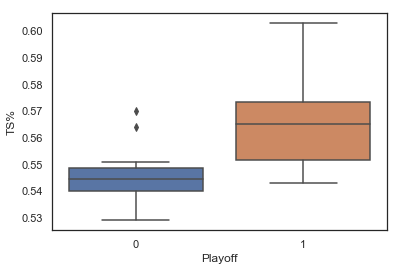

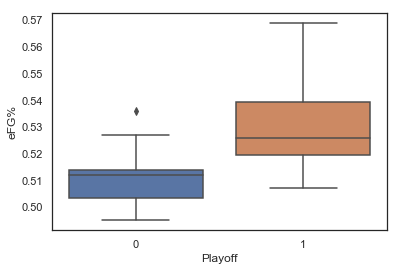

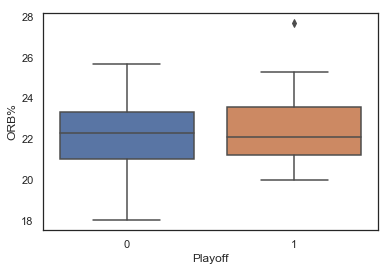

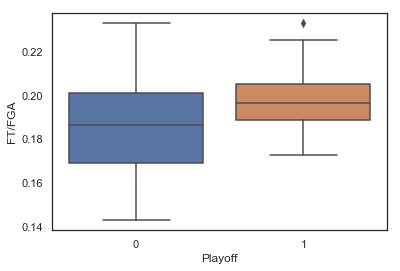

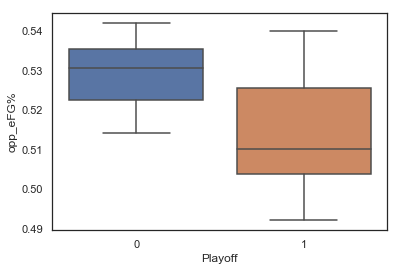

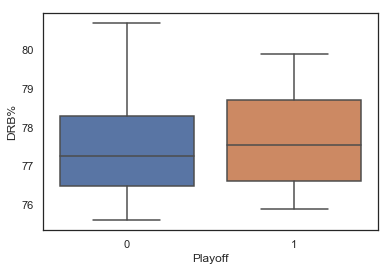

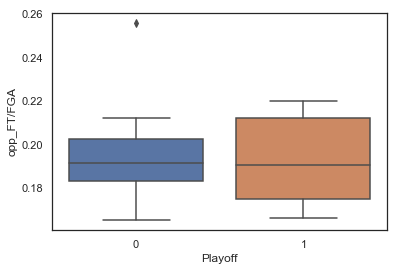

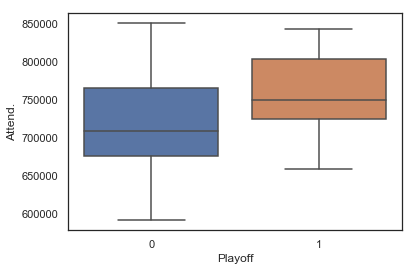

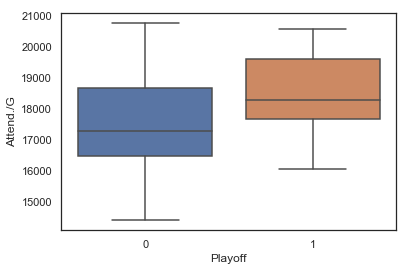

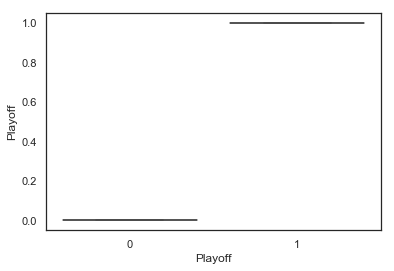

In [54]:
for i in j4.select_dtypes(exclude='object'):
    plt.figure()
    sns.boxplot(x="Playoff", y=i, data=j4)

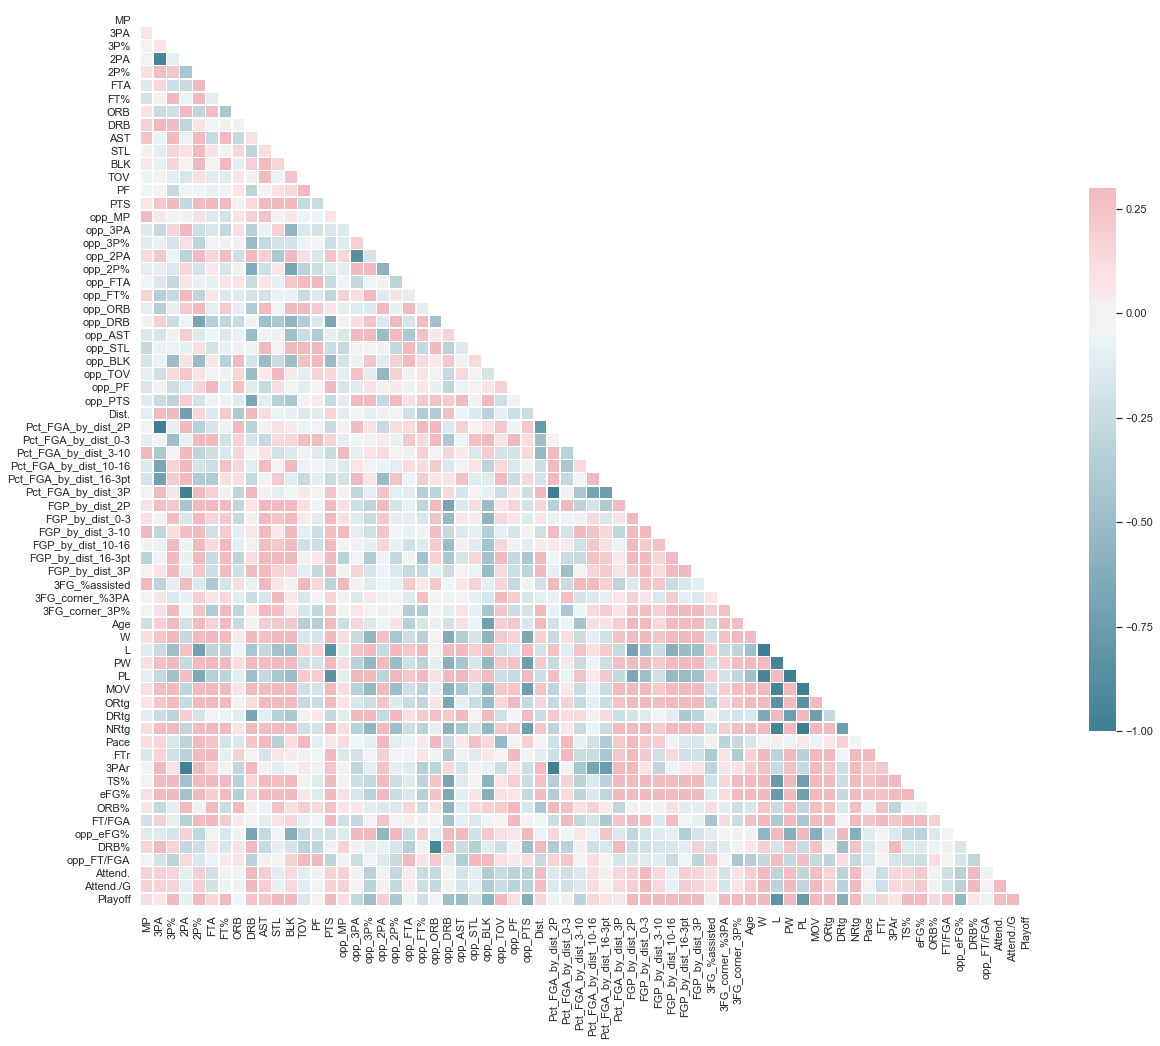

In [55]:
#Correlation Plot

sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = j4

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [59]:
#Summary of full table
#Calculate a normalized standard dev = std/mean of column

summary = j4.describe().T
sigma = np.array(summary[['std']])
mu = np.array(summary[['mean']])
summary['norm_std'] = np.absolute(sigma/mu)
summary.sort_values(by='norm_std', axis = 0, ascending = False)

,count,mean,std,min,25%,50%,75%,max,norm_std
MOV,30.0,0.000333,4.452786,-9.370,-3.43000,0.5350,2.81750,8.480,13358.359219
NRtg,30.0,0.010000,4.537685,-9.300,-3.50000,0.5500,3.00000,8.600,453.768512
Playoff,30.0,0.533333,0.507416,0.000,0.00000,1.0000,1.00000,1.000,0.951405
L,30.0,41.000000,12.222083,17.000,34.00000,38.0000,53.75000,61.000,0.298100
W,30.0,41.000000,12.222083,21.000,28.25000,44.0000,48.00000,65.000,0.298100
PL,30.0,40.933333,11.249317,21.000,33.25000,39.5000,49.75000,63.000,0.274820
PW,30.0,41.066667,11.249317,19.000,32.25000,42.5000,48.75000,61.000,0.273928
Pct_FGA_by_dist_16-3pt,30.0,0.119833,0.031135,0.044,0.10700,0.1210,0.13800,0.191,0.259819
Pct_FGA_by_dist_3-10,30.0,0.156033,0.027234,0.096,0.14050,0.1595,0.16875,0.205,0.174539
Pct_FGA_by_dist_10-16,30.0,0.106100,0.018511,0.062,0.09525,0.1050,0.11400,0.143,0.174464
